In [1]:
import pandas as pd

from fluxo.dados import Dados
from fluxo.carga_dados import CargaDados
from fluxo.limpeza_dados import LimpezaDados
from fluxo.preprocessamento import Preprocessamento
from fluxo.extracao_caracteristicas import ExtracaoCaracteristicas
from fluxo.treinamento import Treinamento
from fluxo.classificador import Classificador
from fluxo.persistencia_modelo import PersistenciaModelo

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import joblib

In [2]:
pd.set_option('max_colwidth', 180)

In [3]:
# Definição do tipo de ato
# Valores válidos: 'ADE', 'SC' ou 'Port.'
# O valor desta variável influencia todo o comportamento deste notebook
tipo_ato = 'ADE'

## Carga de Dados

In [4]:
dados = Dados()

In [5]:
cg = CargaDados()
cg.executar(dados)

21:19:13 - Carregando dados de segmentos...
21:19:14 - 206488 registros carregados.


## Limpeza de Dados

In [6]:
lp = LimpezaDados(dados)
lp.executar(dados, tipo_ato, reclassificar_nao_identificados=False)

21:19:14 - (Re)Carregando segmentos originais...
21:19:14 - Removendo segmentos nulos...
21:19:14 - 1900 segmentos nulos excluídos.
21:19:14 - Restaram 204588 segmentos não nulos.
21:19:14 - Removendo todos os segmentos do tipo Anexo...
21:19:14 - 5771 segmentos do tipo Anexo excluídos.
21:19:14 - Determinando tipos de segmento (labels) para atos do tipo ADE...
21:19:14 - Tipos de segmento para atos ADE: ['Artigo', 'Ementa', 'Fecho', 'Inciso', 'Não Identificado']
21:19:14 - Excluindo segmentos dos atos que não são ADE...
21:19:14 - 88078 segmentos de atos não ADE excluídos.
21:19:14 - Restaram 110739 segmentos de atos ADE.
21:19:14 - Removendo segmentos não representativos para o tipo ADE...
21:19:14 - 2595 segmentos não representativos excluídos.
21:19:14 - Restaram 108144 segmentos representativos.
21:19:14 - Removendo tags HTML...
21:19:14 - Removendo caracteres de escape HTML...
21:19:14 - Limpeza de dados concluída.


## Preprocessamento

In [7]:
pp = Preprocessamento()
pp.executar(dados)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/91872936504/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
21:19:15 - Convertendo caracteres para minúsculo...
21:19:15 - Removendo pontuação...
21:19:16 - Realizando tokenização...
21:19:16 - Removendo stopwords...
21:19:20 - Removendo tokens menores que 2 caracteres...
21:19:21 - Reconstruindo texto a partir dos tokens...
21:19:21 - Preprocessamento concluído.


## Extração de Características

In [8]:
ec = ExtracaoCaracteristicas(dados)
ec.executar(dados, oversampling=True)

21:19:21 - Executando vetorização TF-IDF...
21:19:27 - Executando vetorização TF-IDF para Cross-Validation...
21:20:12 - Extração de características concluída.


## Treinamento e Teste

In [9]:
t = Treinamento()

In [10]:
# Linear SVC (SVM)
estimadorSVC = LinearSVC(random_state=dados.random_state)
t.adicionar_modelo(Classificador('LinearSVC-1xR', estimadorSVC))

# Multinomial Naive Bayes 
estimadorNB = OneVsRestClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1xR', estimadorNB))

In [11]:
t.treinar_modelos(dados)

21:20:12 - Treinando modelo LinearSVC-1xR...
21:20:15 - Treinamento do modelo LinearSVC-1xR concluído.
21:20:15 - Treinando modelo MultinomialNB-1xR...
21:20:15 - Treinamento do modelo MultinomialNB-1xR concluído.


## Treinamento e Teste com Cross-Validation

In [12]:
t = Treinamento()

In [13]:
# Linear SVC (SVM)
estimadorSVC_CV = LinearSVC(random_state=dados.random_state)
t.adicionar_modelo(Classificador('LinearSVC-1xR-CV', estimadorSVC_CV))

# Multinomial Naive Bayes 
estimadorNB_CV = OneVsRestClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1xR-CV', estimadorNB_CV))

In [14]:
t.treinar_modelos(dados, cv=5)

21:20:15 - Treinando modelo LinearSVC-1xR-CV com cross-validation...
21:20:51 - Treinamento do modelo LinearSVC-1xR-CV com cross-validation concluído.
21:20:51 - Treinando modelo MultinomialNB-1xR-CV com cross-validation...
21:21:00 - Treinamento do modelo MultinomialNB-1xR-CV com cross-validation concluído.


## Apresentação de Resultados

In [15]:
resultado = pd.DataFrame(dados.metricas)
resultado.transpose()

,acuracia,precisao,revocacao,f1
LinearSVC-1xR,0.9813,0.9764,0.9754,0.9759
MultinomialNB-1xR,0.9297,0.9282,0.9258,0.9259
LinearSVC-1xR-CV,0.9849,0.9850,0.9849,0.9848
MultinomialNB-1xR-CV,0.9351,0.9357,0.9351,0.9344


In [16]:
#print(resultado.transpose().to_latex())

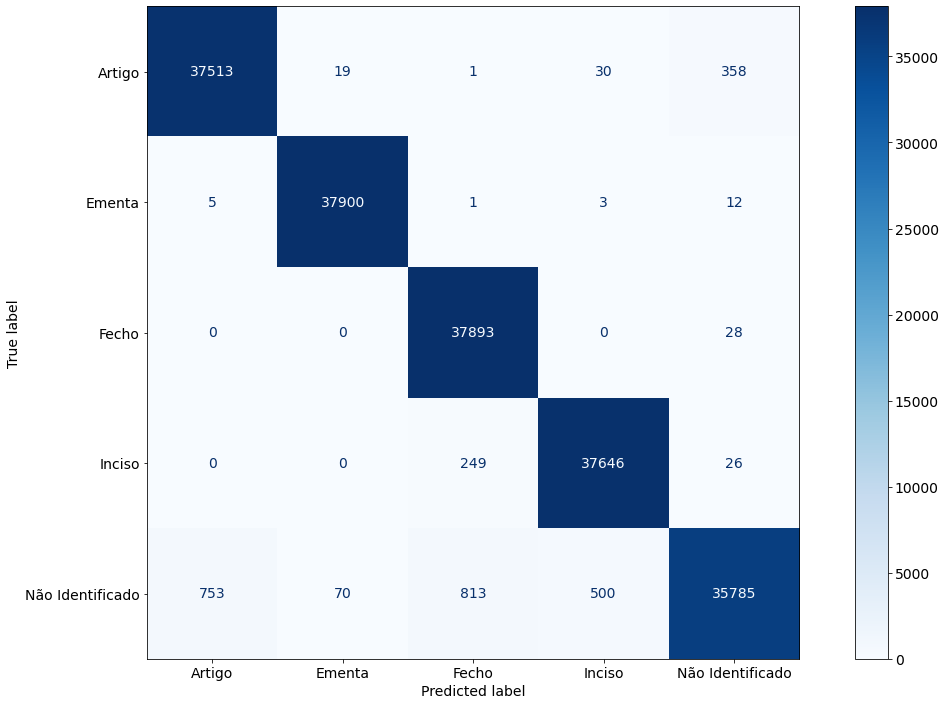

In [17]:
clf = Classificador('LinearSVC-1xR-CV', estimadorSVC_CV)
clf.treinar_com_cv(dados, cv=5)
clf.plotar_matriz_confusao(dados)

## Persistindo o modelo treinado

In [18]:
pm = PersistenciaModelo('ADE')
pm.salvar_modelo(estimadorSVC_CV)

21:21:39 - Salvando modelo treinado para o tipo ADE...
21:21:39 - Modelo salvo em ./modelos/classificador-segmentos-ade.mdl.
